In [ ]:
 from __future__ import print_function
from keras.models import Sequential
from keras import layers
from keras.layers import *
import numpy as np
import csv
from keras.utils import plot_model
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

MAXLEN = 47

with open('/content/drive/My Drive/Datensatz/out_strassen2.csv', newline='') as f:
    reader = csv.reader(f)
    # zip(*) transpose rows to columns
    data = list(zip(*list(reader)))
train = list(data[0])
test = list(data[1])
for i in range(len(train)):
    train[i] = "{:<47}".format(train[i])
    test[i] = "{:<47}".format(test[i])

chars = {'Ü', 'C', 'l', 'g', 'ö', '3', 'W', 'A', 'm', 'N', 'P', 'e', 'k', 'B', 'y', 'Ä', '4', 'z', '2', '1', 'x', 'ß', 'L', 'i', "'", '-', 'E', 'c', '_', 'J', 'h', 'X', 't', '6', 'r', 'I', 'O', 'ü', 'H', '8', 's', 'D', 'v', 'Z', 'Ö', 'F', 'U', 'b', '.', 'f', 'w', 'o', '/', 'T', 'n', 'R', 'a', '7', ' ', 'K', 'Q', 'Y', 'u', 'M', 'ä', 'd', 'p', 'V', '9', 'q', '&', '5', ',', 'j', ')', '0', '(', 'S', 'G'}
ctable = CharacterTable(chars)

print('Vectorization...')
x = np.zeros((len(train), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(train), MAXLEN, len(chars)), dtype=np.bool)
for i, sentence in enumerate(train):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(test):
    y[i] = ctable.encode(sentence, MAXLEN)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

split_at = len(x) - len(x) // 20
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250


# plot_model(model, show_shapes=True)



Vectorization...


In [ ]:
# import tensorflow.compat.v1.keras.layers.CuDNNLSTM
print('Build model...')
model = Sequential()
# model.add(layers.Conv1D(256, KERNEL_SIZE, padding='valid', activation='relu', strides=1, input_shape=(MAXLEN, len(chars))))
# model.add(layers.MaxPooling1D())
# model.add(layers.Bidirectional(RNN(HIDDEN_SIZE)))
# model.add(layers.RepeatVector(MAXLEN))
# model.add(layers.Bidirectional(RNN(HIDDEN_SIZE,return_sequences=True)))
# model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))


model.add(Bidirectional(LSTM(256, return_sequences=True), name="bi_rnn1", input_shape=(None, len(chars))))
model.add(SpatialDropout1D(0.25, name="bi_rnn1_spdp"))
model.add(Bidirectional(LSTM(256, return_sequences=True), name="bi_rnn2"))
model.add(SpatialDropout1D(0.25, name="bi_rnn2_spdp"))
model.add(Bidirectional(LSTM(256, return_sequences=True), name="bi_rnn3"))
model.add(SpatialDropout1D(0.25, name="bi_rnn3_spdp"))
model.add(Bidirectional(LSTM(256, return_sequences=True), name="bi_rnn4"))
model.add(SpatialDropout1D(0.25, name="bi_rnn4_spdp"))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bi_rnn1 (Bidirectional)      (None, None, 512)         688128    
_________________________________________________________________
bi_rnn1_spdp (SpatialDropout (None, None, 512)         0         
_________________________________________________________________
bi_rnn2 (Bidirectional)      (None, None, 512)         1574912   
_________________________________________________________________
bi_rnn2_spdp (SpatialDropout (None, None, 512)         0         
_________________________________________________________________
bi_rnn3 (Bidirectional)      (None, None, 512)         1574912   
_________________________________________________________________
bi_rnn3_spdp (SpatialDropout (None, None, 512)         0         
_________________________________________________________________
bi_rnn4 (Bidirectional)      (None, None,

In [ ]:
history = []
for iteration in range(1, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    history.append(model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=3,
              validation_data=(x_val, y_val)))
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Epoch 1/3
5807/5807 [==============================] - 545s 91ms/step - loss: 0.2134 - accuracy: 0.9470 - val_loss: 0.0282 - val_accuracy: 0.9921
Epoch 2/3
5807/5807 [==============================] - 529s 91ms/step - loss: 0.0288 - accuracy: 0.9918 - val_loss: 0.0216 - val_accuracy: 0.9936
Epoch 3/3
5807/5807 [==============================] - 526s 91ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0200 - val_accuracy: 0.9941


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Q Röhrichatr.                                     T Röhrichstr.                                     ☑ Röhrichstr.                                    
Q Exhternweg                                      T Echternweg                                      ☑ Echternweg                                     
Q Wickingweg                                      T Wickingweg                                      ☑ Wickingweg                                     
Q Zur Jägerkuhle                                  T Zur Jägerkuhle                                  ☑ Zur Jägerkuhle                                 
Q Am Leenenhäuschen                               T Am Leinenhäuschen                               ☒ Am Leenenhäuschen                              
Q Im Fritxeeck                                    T Im Fritzeeck                                    ☑ Im Fritzeeck                                   
Q Ecklingeröder Str.                              T Ecklingeröder Str.                              

In [ ]:
model.save("/content/drive/MyDrive/cft_strassen")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cft_strassen/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/cft_strassen/assets


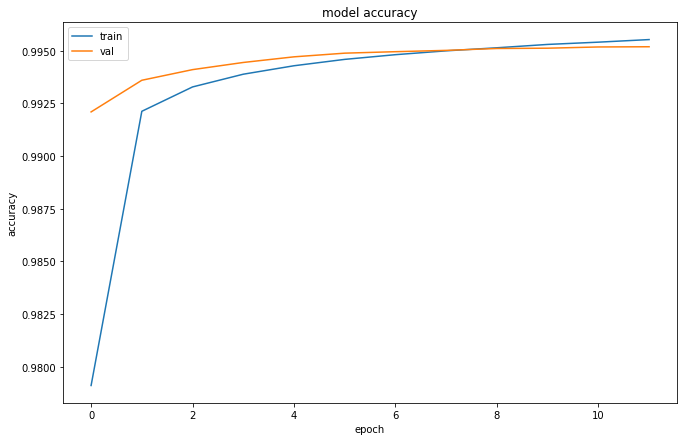

In [ ]:
accuracies = []
val_accuracies = []
for hist in history:
  accuracies.append(hist.history['accuracy'])
  val_accuracies.append(hist.history['val_accuracy'])
accuracies = np.array(accuracies).flatten()
val_accuracies = np.array(val_accuracies).flatten()

from matplotlib import pyplot as plt
plt.figure(figsize=(11, 7))
plt.plot(accuracies)
plt.plot(val_accuracies)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict_classes(x_val, verbose=0)
counter = 0
for i in range(len(x_val)):
  q = ctable.decode(x_val[i])
  correct = ctable.decode(y_val[i])
  guess = ctable.decode(preds[i], calc_argmax=False)
  # print(f'Q {q} T {correct} G {guess}')

  if(correct==guess):
    counter += 1
print(counter/len(x_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8190719672759811
